In [1]:
import requests
import pandas as pd
from barentswatch.credentials import config
from barentswatch.authentication import get_token
import warnings
from pprintpp import pprint
warnings.simplefilter(action='ignore', category=FutureWarning)

###### Using API to get data

Link to ApiDocs: https://www.barentswatch.no/bwapi/openapi/index.html?urls.primaryName=Fishhealth%20API

In [2]:
from functions import get_week_summary

In [3]:
token = get_token()
weeksummary= get_week_summary(token,'2017','45')
type(weeksummary)

Token request successful


dict

##### Storing information from the entire year in table

In [4]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()


for week in range(1, 53):
    print(f'Inserting data for week {week}...')
    weeksummary = get_week_summary(token, '2021', str(week))

    for locality in weeksummary['localities']:
        session.execute(
            insert_query,
            (
                weeksummary['year'],
                weeksummary['week'],
                locality['localityNo'],
                locality['localityWeekId'],
                locality['name'],
                locality['hasReportedLice'],
                locality['isFallow'],
                locality['avgAdultFemaleLice'],
                locality['hasCleanerfishDeployed'],
                locality['hasMechanicalRemoval'],
                locality['hasSubstanceTreatments'],
                locality['hasPd'],
                locality['hasIla'],
                locality['municipalityNo'],
                locality['municipality'],
                locality['lat'],
                locality['lon'],
                locality['isOnLand'],
                locality['inFilteredSelection'],
                locality['hasSalmonoids'],
                locality['isSlaughterHoldingCage']
            )
        )

##### Activating pyspark

In [5]:
import os

os.environ["PYSPARK_PYTHON"] = r"C:\Users\holml\anaconda3\envs\IND320_ml\python.exe" 
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\holml\anaconda3\envs\IND320_ml\python.exe"
os.environ["HADOOP_HOME"] = r"C:\Source\winutils\hadoop-3.3.1"
os.environ["PYSPARK_HADOOP_VERSION"] = r"C:\Source\winutils\hadoop-3.3.1"

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

#### Checking that the data has been inserted as intended

In [7]:
#### Checking that the data has been inserted as intended
spark.read.format("org.apache.spark.sql.cassandra").options(table="locality_data", keyspace="fish_data").load().show()

+--------------+------------------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+------------+--------------+--------------+----+----+
|localityweekid|avgadultfemalelice|hascleanerfishdeployed|hasila|hasmechanicalremoval|haspd|hasreportedlice|hassalmonoids|hassubstancetreatments|infilteredselection|isfallow|isonland|isslaughterholdingcage|      lat|localityno|      lon|municipality|municipalityno|          name|week|year|
+--------------+------------------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+------------+--------------+--------------+----+----+
|       1271584|               0.0|                 false| false|               false|false|           true|         true|     

In [8]:
spark.read.format("org.apache.spark.sql.cassandra")\
.options(table="locality_data", keyspace="fish_data").load()\
.createOrReplaceTempView("locality_view")

df_locality = spark.sql("select * from locality_view").toPandas()

In [9]:
def assign_region(lat):
    if lat < 63.81:
        return 'South'
    elif lat <= 68.85:
        return 'Middle'
    else:
        return 'North'

In [10]:
print(df_locality.shape)

df_locality['region'] = df_locality['lat'].apply(assign_region)
df_locality.head()

(88475, 21)


,localityweekid,avgadultfemalelice,hascleanerfishdeployed,hasila,hasmechanicalremoval,haspd,hasreportedlice,hassalmonoids,hassubstancetreatments,infilteredselection,...,isslaughterholdingcage,lat,localityno,lon,municipality,municipalityno,name,week,year,region
0,1226735,NaN,False,False,False,False,False,True,False,True,...,False,63.994950,19977,9.928317,Åfjord,5058,Jektholmen,13,2021,Middle
1,1193801,0.11,False,False,False,False,True,True,False,True,...,False,68.823767,36118,15.400217,Sortland,1870,Bremnesøya,4,2021,Middle
2,1284666,0.00,False,False,False,False,True,True,False,True,...,False,59.907150,11605,5.159333,Fitjar,4615,Soløy Ø,33,2021,South
3,1293337,0.04,False,False,False,False,True,True,False,True,...,False,63.761867,12394,8.445183,Frøya,5014,Ørnøya,36,2021,South
4,1194192,NaN,False,False,False,False,False,True,False,True,...,True,59.226617,11969,5.853783,Stavanger,1103,Helgøy,4,2021,South


In [11]:
#Group by week and avgAdultFemaleLice
df_grouped = df_locality.groupby(['week', 'avgadultfemalelice']).size().reset_index(name='counts')

In [12]:

df_pivot1 = df_locality.pivot_table(index='hasila', columns='haspd', values=['lat', 'lon'], aggfunc='mean')
df_pivot1.head()

lat                   lon          
haspd       False      True       False     True 
hasila                                           
False   64.127945  61.451657  10.855804  6.409310
True    67.357973  59.295500  16.327834  5.938617

##### Comments about pivot table1

We see that the mean latitude for False and False is further North than True and True. Colder water further north could be a reason for this to happen.

<Axes: xlabel='week'>

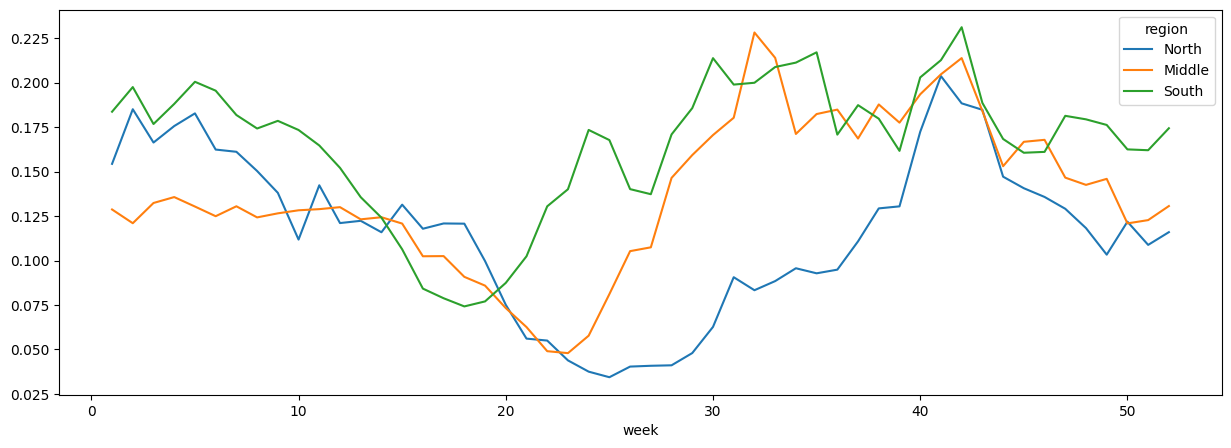

In [13]:
df_pivot2 = df_locality.pivot_table(index='week', columns='region',\
                                    values='avgadultfemalelice', aggfunc='mean')
df_pivot2.plot(y=['North', 'Middle', 'South'], kind='line', figsize=(15, 5))

#df_pivot2.head(52)

#### Comments on plot

From the plot we see that the amount of lice. It corresponds with the seatemperature, which makes sense since the viruses thrives/grotwth best in warm water. 
Maybe the delay from summer is due to "golfstrømmen" will need time to reach norway?

### Doing it with using the API

- Yields more specific information about the locality.

In [14]:
from functions import get_detailed_week_summary

data = []
localityid = 35297
for week in range(1, 53):
    weeksummary = get_detailed_week_summary(token, '2022', str(week), localityid)
    locality_week_data = weeksummary['localityWeek']
    datetime_object = pd.to_datetime('{}-W{}-7'.format(locality_week_data['year'],\
                                    locality_week_data['week']), format='%G-W%V-%u')
    weekly_data = {
    'datetime': datetime_object,
    'avgadultfemalelice': locality_week_data['avgAdultFemaleLice'],
    'hasreportedlice': locality_week_data['hasReportedLice'],
    'avgmobilelice': locality_week_data['avgMobileLice'],
    'avgstationarylice': locality_week_data['avgStationaryLice'],
    'seatemperature': locality_week_data['seaTemperature']
    }
    data.append(weekly_data)
df_35297 = pd.DataFrame(data)
df_35297['datetime'] = df_35297['datetime'].dt.strftime('%Y-%U')
df_35297.head(3)

,datetime,avgadultfemalelice,hasreportedlice,avgmobilelice,avgstationarylice,seatemperature
0,2022-01-09,0.05,True,0.14,0.05,6.1
1,2022-01-16,0.06,True,0.44,0.04,5.5
2,2022-01-23,0.09,True,0.35,0.01,6.9


<Axes: xlabel='datetime'>

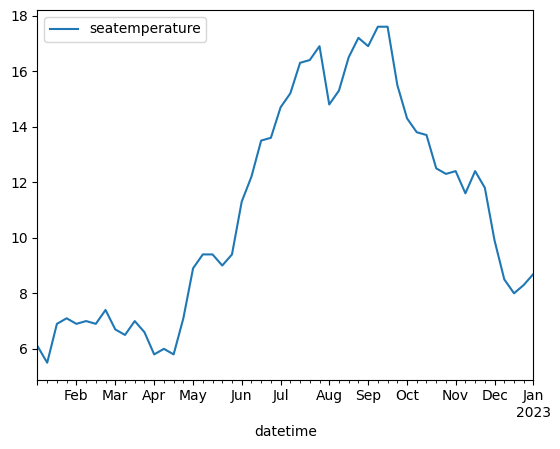

In [15]:
#plot seaTemperature
df_35297.plot(x='datetime', y='seatemperature')

#### Seeing the correlation between seatemperature and "mobilse, stationary and adultfemalelice"

In [16]:
from matplotlib import pyplot as plt

import numpy as np
from ipywidgets import interact

def lagged_correlation_plot(lag=0, window=45, center=22, variable='avgadultfemalelice'):
    corr = np.corrcoef(y[lag:], x[variable][0:len(x)-lag])

    z = x[variable].copy()
    z.index += lag
    seatemp_SWC = y.rolling(window, center=True).corr(z)
#    PerEURO_SWC = y[lag:].rolling(window, center=True).corr(x[variable][:len(x)-lag])

    # Plot Seatemperature, [] and PerEUROs_SWC as subplots
    plt.subplot(3,1,1)
    plt.plot(df_35297['seatemperature'])
    plt.plot(range(np.max([0,center-window//2+lag]),np.min([center+window//2+lag, len(y)])), \
        df_35297['seatemperature'][np.max([0,center-window//2+lag]):np.min([center+window//2+lag, len(y)])], color="red")
    plt.ylabel('seatemperature')
    plt.xlim(0, len(y))
    plt.subplot(3,1,2)
    plt.plot(df_35297[variable])
    plt.plot(range(np.max([0,center-window//2]),np.min([center+window//2, len(y)])), \
        df_35297[variable][np.max([0,center-window//2]):np.min([center+window//2, len(y)])], color="red")
    plt.ylabel(variable)
    plt.xlim(0, len(y))
    plt.subplot(3,1,3)
    plt.plot(seatemp_SWC)
    plt.plot(center+lag, seatemp_SWC[center+lag], 'r.')
    plt.axhline(y=0, color='gray', linestyle=':')
    plt.ylim(-1,1)
    plt.xlim(0, len(y))
    plt.xlabel('Time')
    plt.ylabel('°C')
    plt.show()
    print("Correlation between {} and {} lagged {} timepoints: {:.3f}".format(y.name, variable, lag, corr[0,1]))

x = df_35297
y = df_35297['seatemperature']
interact(lagged_correlation_plot, lag=(0,52,1), window=(1,52,1), center=(0,len(df_35297['seatemperature'])-22,1),\
        variable=["avgadultfemalelice", "avgmobilelice", "avgstationaryulice"]); # Semi-colon to suppress output


interactive(children=(IntSlider(value=0, description='lag', max=52), IntSlider(value=45, description='window',…

In [17]:

spark.createDataFrame(df_35297).write.format("org.apache.spark.sql.cassandra")\
.options(table="id_35297", keyspace="fish_data").mode("append").save()

In [18]:
spark.read.format("org.apache.spark.sql.cassandra").options(table="id_35297", keyspace="fish_data").load().show()

+-------------------+------------------+-------------+-----------------+---------------+--------------+
|           datetime|avgadultfemalelice|avgmobilelice|avgstationarylice|hasreportedlice|seatemperature|
+-------------------+------------------+-------------+-----------------+---------------+--------------+
|2022-05-29 00:00:00|              0.18|         0.75|             0.06|           true|           9.4|
|2022-07-10 00:00:00|              0.14|         1.36|             0.25|           true|          15.2|
|2022-11-20 00:00:00|              0.05|         0.28|             0.02|           true|          12.4|
|2022-10-16 00:00:00|               0.1|         0.43|              0.0|           true|          13.7|
|2022-06-26 00:00:00|              0.06|         0.45|             0.02|           true|          13.6|
|2022-10-02 00:00:00|              0.23|          0.6|              0.0|           true|          14.3|
|2022-04-03 00:00:00|              0.18|         0.52|          

### Inserting the weather data from Frost

In [19]:
from frost_credentials.credentials import ID
import requests
client_id = ID['client_id']
client_secret = ID['client_secret']

In [20]:
id = "SN65310"

In [21]:
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': f'{id}',
    'elements': 'mean(air_temperature P1D),\
        sum(precipitation_amount P1D),\
        mean(wind_speed P1D),\
        mean(relative_humidity P1D),\
        mean(seaTemperature P1D),)',
    'referencetime': '2022-01-01/2023-01-01'}
r = requests.get(endpoint, parameters, auth=(client_id,''))

json = r.json()

if r.status_code == 200:
    obs_data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [22]:
import pandas as pd


In [23]:
# This will return a Dataframe with all of the observations in a table format
df_total = pd.DataFrame()
for i in range(len(obs_data)):
    row = pd.DataFrame(obs_data[i]['observations'])
    row['referenceTime'] = obs_data[i]['referenceTime']
    row['sourceId'] = obs_data[i]['sourceId']
    df_total = pd.concat([df_total, row])

In [37]:
# These additional columns will be kept
columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset']
df = df_total[columns].copy()
df["referenceTime"] = pd.to_datetime(df["referenceTime"])
# Convert the time value to something Python understands
# Define the conversion function
def convert_date_to_week_year(date):
    date_obj = pd.to_datetime(date)
    week = date_obj.week
    year = date_obj.year
    # Change week 53 to 0
    if week == 53:
        week = 0
    return f"{year}, {week}"

# Apply the function to the DataFrame column
df['datetime'] = df['referenceTime'].dt.strftime('%Y-%U')


In [38]:
df.head()

,sourceId,referenceTime,elementId,value,unit,timeOffset,datetime
0,SN65310:0,2022-01-01 00:00:00+00:00,mean(air_temperature P1D),3.0,degC,PT0H,2022-00
1,SN65310:0,2022-01-01 00:00:00+00:00,mean(air_temperature P1D),4.6,degC,PT6H,2022-00
2,SN65310:0,2022-01-01 00:00:00+00:00,mean(wind_speed P1D),6.4,m/s,PT0H,2022-00
3,SN65310:0,2022-01-01 00:00:00+00:00,mean(relative_humidity P1D),72.0,percent,PT0H,2022-00
0,SN65310:0,2022-01-02 00:00:00+00:00,mean(air_temperature P1D),6.8,degC,PT0H,2022-01


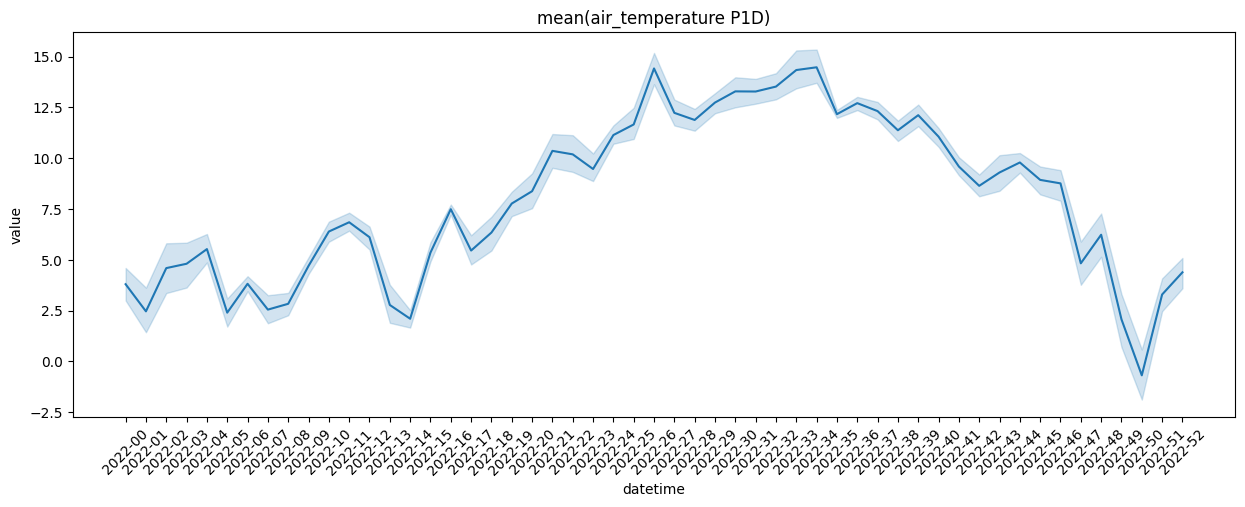

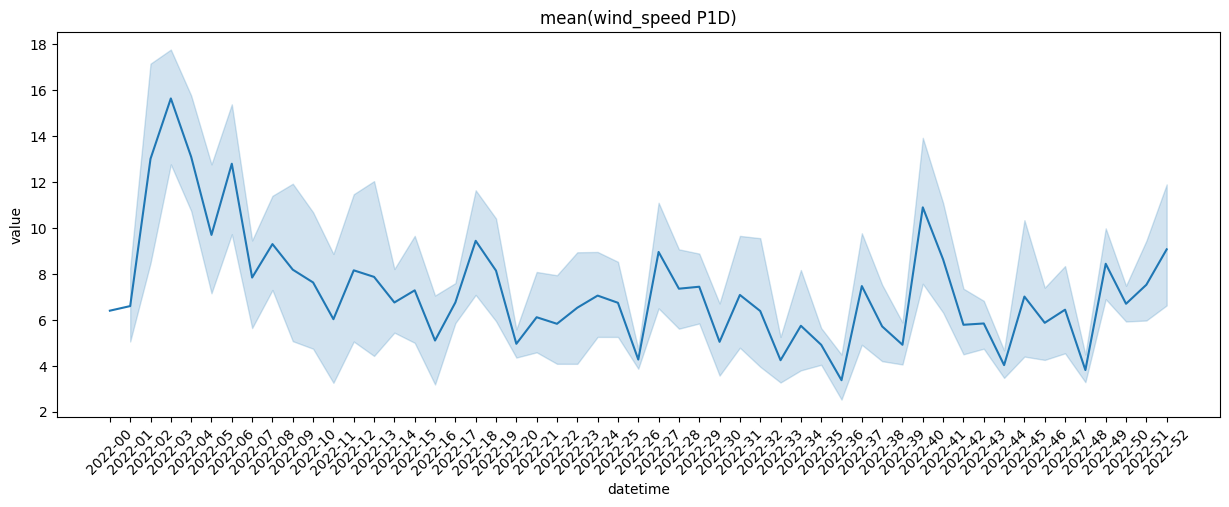

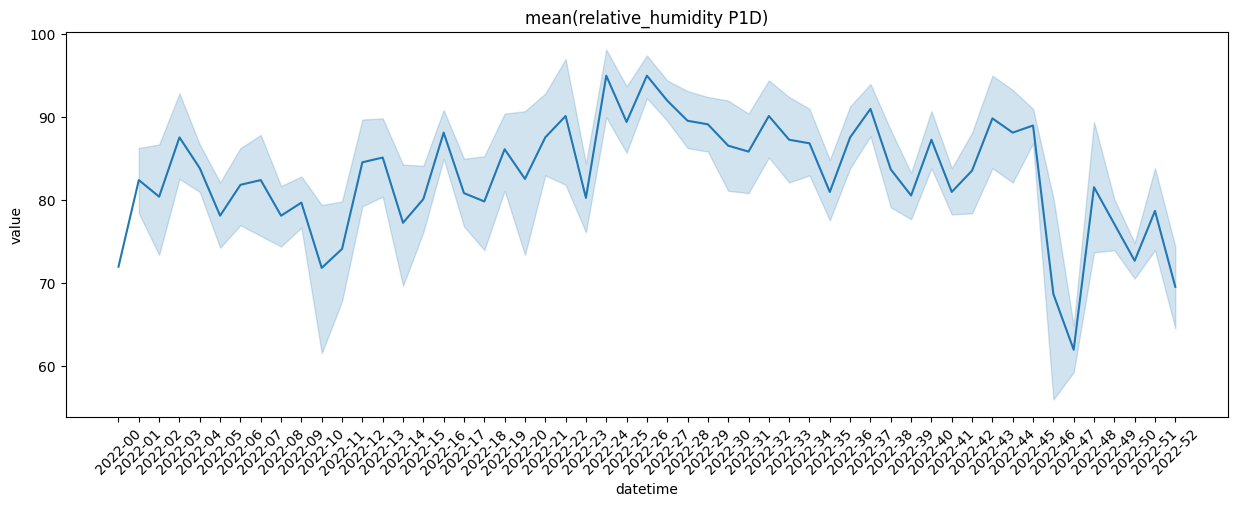

In [42]:
#Plot each of the unique elements from elementId, where x is the referenceTime and y is the value
import matplotlib.pyplot as plt
import seaborn as sns

for element in df['elementId'].unique():
    df_element = df[df['elementId'] == element]    
    plt.figure(figsize=(15,5))
    sns.lineplot(x='datetime', y='value', data=df_element)
    plt.title(element)
    plt.xticks(rotation=45)
    plt.show()

##### Mergind the weather dataset with fishhealth dataset based on timepoints.

ValueError: unconverted data remains when parsing with format "%Y-%m-%d": "T00:00:00.000Z", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
df.head(100)
#df_35297.head(100)

#Merge the two dataframes on datetime, but match the dates to each other to expand the data
df_merged2 = pd.merge(df_35297, df, on='datetime', how='outer')

,sourceId,elementId,value,unit,timeOffset,datetime
0,SN65310:0,mean(air_temperature P1D),0.8,degC,PT0H,2021-01-01 00:00:00+00:00
1,SN65310:0,mean(air_temperature P1D),1.7,degC,PT6H,2021-01-01 00:00:00+00:00
2,SN65310:0,mean(wind_speed P1D),2.7,m/s,PT0H,2021-01-01 00:00:00+00:00
3,SN65310:0,mean(relative_humidity P1D),81.0,percent,PT0H,2021-01-01 00:00:00+00:00
0,SN65310:0,mean(air_temperature P1D),1.8,degC,PT0H,2021-01-02 00:00:00+00:00
...,...,...,...,...,...,...
3,SN65310:0,mean(relative_humidity P1D),76.0,percent,PT0H,2021-01-24 00:00:00+00:00
0,SN65310:0,mean(air_temperature P1D),2.5,degC,PT0H,2021-01-25 00:00:00+00:00
1,SN65310:0,mean(air_temperature P1D),3.7,degC,PT6H,2021-01-25 00:00:00+00:00
2,SN65310:0,mean(wind_speed P1D),6.7,m/s,PT0H,2021-01-25 00:00:00+00:00


In [ ]:
dataframes = [df_35297, df]

df_merged = pd.concat(dataframes)

In [ ]:
df_merged.head()

,datetime,avgadultfemalelice,hasreportedlice,avgmobilelice,avgstationarylice,seatemperature,sourceId,elementId,value,unit,timeOffset
0,2022-01-09 00:00:00,0.05,True,0.14,0.05,6.1,NaN,NaN,NaN,NaN,NaN
1,2022-01-16 00:00:00,0.06,True,0.44,0.04,5.5,NaN,NaN,NaN,NaN,NaN
2,2022-01-23 00:00:00,0.09,True,0.35,0.01,6.9,NaN,NaN,NaN,NaN,NaN
3,2022-01-30 00:00:00,0.09,True,0.34,0.06,7.1,NaN,NaN,NaN,NaN,NaN
4,2022-02-06 00:00:00,0.25,True,0.92,0.18,6.9,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_merged.loc[:, df_merged.columns[-4:-2]]
# Use df.loc to locate column 0, -4 and -2
df_merged.loc[:, df_merged.columns[[0, -4, -2]]]



,datetime,elementId,unit
0,2022-01-09 00:00:00,NaN,NaN
1,2022-01-16 00:00:00,NaN,NaN
2,2022-01-23 00:00:00,NaN,NaN
3,2022-01-30 00:00:00,NaN,NaN
4,2022-02-06 00:00:00,NaN,NaN
...,...,...,...
3,2021-12-30 00:00:00+00:00,mean(relative_humidity P1D),percent
0,2021-12-31 00:00:00+00:00,mean(air_temperature P1D),degC
1,2021-12-31 00:00:00+00:00,mean(air_temperature P1D),degC
2,2021-12-31 00:00:00+00:00,mean(wind_speed P1D),m/s


In [ ]:
import statsmodels.api as sm

In [ ]:
# Get predictions for the whole dataset
mod = sm.tsa.statespace.SARIMAX(endog=df_merged['seatemperature'],\
                                exog = df_merged.loc[:, df_merged.columns[-4:-2]], \
    trend='c', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.filter(res.params) # One-stpe-ahead predictions
res = mod.fit(disp=False)

TypeError: '>=' not supported between instances of 'float' and 'str'

In [ ]:
# In-sample one-step-ahead prediction wrapper function
predict = res.get_prediction()
predict_ci = predict.conf_int()

In [ ]:
# Dynamic predictions starting from 2013-01-01
predict_dy = res.get_prediction(dynamic='2013-01-01')
predict_dy_ci = predict_dy.conf_int()

In [ ]:
# Compare the one-step-ahead predictions to the dynamic predictions
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Exchange rate', xlabel='Date', ylabel='seatemperature')

# Plot data points
OilExchange.loc['2012-01-01':, 'seatemperature'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2012-01-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2012-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2012-01-01':].plot(ax=ax, style='g', label='Dynamic forecast (2013)')
ci = predict_dy_ci.loc['2012-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')